In [1]:
from light_curves import LightCurve
from exposures import Calexp
from task import Run
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
radius = 0.2 #[0.1,0.2,0.3, 0.5]
density = 50/0.05#]np.array([10,50, 100, 500])/0.05
n_max_calexps = 4000
bands = "ugrizy"
problems = []
delta_mag = np.array([10,7,4,2,1,0])
# start = False
# for dens in density:
#     for r in radius:

process = Run(ra=57.59451632893858, dec=-32.481152201226145, density = density, scale = radius, 
              band = bands, name = f"run_{density:.0f}dens_{int(radius*10):02d}rad_{bands}", method="overlap")
print(process)
process.inject_task()
schema = process.measure_task()

process.collect_calexp()
process.data_calexp.to_csv(process.main_path+'/data_calexp.csv', index=False)
for event_id, m in enumerate(np.linspace(17,22,process.n_lc)):
    lc_ra, lc_dec = process.generate_location()
    params = {"t_0": random.uniform(60300,61500),
   "t_E": random.uniform(20, 200), 
   "u_0": random.uniform(0.1,1)}
    for band, dm in zip(process.band, delta_mag):
        params["m_base"]=m+dm
        process.add_lc(lc_ra, lc_dec, params, event_id=event_id, band=band)
process.data_events.to_csv(process.main_path+'/data_events.csv', index=False) 
# process.sky_map()
process.log_task("Add and simulate light curves")



for idx, data in process.data_calexp.iterrows():
    if idx >= n_max_calexps:
        break
    print(f" ------ CALEXP {idx+1}/{n_max_calexps} ------")
    dataId = data[['visit', 'detector']].to_dict()
    calexp = Calexp(dataId)
    band = data["band"]
    ax = calexp.plot() # plotear cada calexp con los puntos a inyectar y chequear si efectivamente contiene la cantidad que la funcion de inyeccion dice que contiene
    for lc in process.inj_lc:
        calexp.add_point(ax, lc.ra, lc.dec, r=40)
    plt.show()
    if calexp.overlaps(process.region):
        data_id = calexp.data_id
        process.data_calexp.loc[(process.data_calexp["detector"] == data_id["detector"]) & (process.data_calexp["visit"] == data_id["visit"]),"overlap"] = True
        injection_catalog = process.create_injection_table(calexp, band)
        injection_catalog_checked = process.check_injection_catalog(calexp, catalog = injection_catalog)
        
        print(f"{injection_catalog=}")
        if injection_catalog:
            print(f"{band=}")
            injected_exposure, injected_catalog = process.inject_calexp(calexp, injection_catalog_checked, save_fit=f"calexp_{idx}_{band}.fit")
            if injected_catalog != None:
                inj_calexp = Calexp(injected_exposure)
                ax = inj_calexp.plot() # plotear cada calexp con los puntos a inyectar y chequear si efectivamente contiene la cantidad que la funcion de inyeccion dice que contiene
                for lcc in injected_catalog:
                    if lcc["injection_flag"] != 0:
                        color = "cyan"
                    else:
                        color = "red"
                    inj_calexp.add_point(ax, lcc["ra"], lcc["dec"], r=40, c=color)
                plt.show()
                
                print(f"{injected_catalog=}")
                injected_catalog_checked = process.check_injection_catalog(calexp, injected_catalog, before_injection=False)
                print(f"{injected_catalog_checked=}")
                if len(injected_catalog_checked)>0:
                    sources = process.measure_calexp(injected_exposure, schema)
                    for lc_inj in injected_catalog_checked:
                        flux, flux_err = process.find_flux(sources, lc_inj["ra"], lc_inj["dec"], save=dataId)
                        if flux != None:
                            filtered_idx = process.data_events[
                                (process.data_events["ra"] == lc_inj["ra"]) &
                                (process.data_events["dec"] == lc_inj["dec"]) &
                                (process.data_events["band"] == band)].index
                            id_lc_inj = filtered_idx[0] if not filtered_idx.empty else None
                            lc = process.inj_lc[id_lc_inj]
                            mag, mag_err = calexp.get_mag(flux, flux_err)
                            lc.add_data(data_id, ["flux", "flux_err", "mag", "mag_err"], [flux, flux_err, mag, mag_err])
                            print("-"*50)
                            print(f"ra = {lc.ra}, dec = {lc.dec}, id = {id_lc_inj}, band = {lc.band}")
                            print("Measured ", mag, mag_err)
                            print("Injected", lc.data["mag_sim"][idx])
                            is_within_range = (mag - mag_err <= lc.data["mag_sim"][idx] <= mag + mag_err)
                            print("Injected within range:", is_within_range)
                            # print("Injected inj_catalog ", lc_inj["mag"])
                            try:
                                if abs(mag-lc.data["mag_sim"][idx])>1:
                                    problems.append((idx, calexp, process.inj_lc[id_lc_inj], lc.ra , lc.dec, sources, injected_catalog, injected_catalog_checked, mag, mag_err, lc.data["mag_sim"][idx], injected_exposure))
                            except Exception as e:
                                print(f"flag: {e}")
            # injected_catalog_checked =  process.check_injection_catalog(calexp, injected_catalog)
            # if len(injected_catalog_checked)>0:
            #     sources = process.measure_calexp(injected_exposure, schema)
            #     flux, flux_err = process.find_flux(sources, injected_catalog_checked, save=dataId)
            #     for i, (f, ferr) in enumerate(zip(flux, flux_err)):
            #         if i in injected_catalog_checked["injection_id"]:
            #             flag = injected_catalog_checked[injected_catalog_checked["injection_id"]==i]["injection_flag"]
            #             if f is not np.nan and flag!=0:
            #                 mag, mag_err = "FLAG", "FLAG"
            #             else:
            #                 mag, mag_err = calexp.get_mag(f, ferr)
            #             lc = process.inj_lc[i]
            #             lc.add_mag(mag, mag_err, dataId)
            #             print(f"ra = {lc.ra}, dec = {lc.dec}")
            #             print("Measured ", mag, mag_err)
            #             print("Injected ", lc.data["mag_sim"][idx])
                        # try:
                        #     if abs(mag-lc.data["mag_sim"][idx])>1:
                        #         problems.append((idx, calexp, lc.ra , lc.dec, sources, injected_catalog, injected_catalog_checked, mag, mag_err, lc.data["mag_sim"][idx], injected_exposure))
                        # except:
                        #     print("flag")
        else:
            print("Injection catalog is empty")
    else:
        print("Not intersection between calexp and region.")
            
process.data_calexp.to_csv(process.main_path+'/data_calexp.csv', index=False)
process.data_events.to_csv(process.main_path+'/data_events.csv', index=False)  
process.save_lc()
process.save_time_log()
process.time_analysis()
print("Inj points", [lc.data["mag"].count() for lc in process.inj_lc] )
process.sky_map(calexps=n_max_calexps)


--------------------------------------------------------------------------------
Run Name: run_1000dens_02rad_ugrizy
Center: RA=57.59451632893858, Dec=-32.481152201226145
Band: ugrizy
Method: overlap
Density: 1000.0 sources/deg²
Area: 0.13 deg²
Number of LightCurves to inject: 126
Main Path: runs/run_1000dens_02rad_ugrizy
--------------------------------------------------------------------------------
(ra,dec) = (57.59451632893858, -32.481152201226145) 
Circle of radius ~0.20 deg.
Found 3304 calexps.


In [19]:
len([i.data["mag"].values[0] for i in process.inj_lc if i.data["mag"].values[0] != a ])

756

In [21]:
sum(np.isnan([i.data["mag"].values[0] for i in process.inj_lc]))

639

In [26]:
len([dataRef for dataRef in process.datasetRefs if dataRef.dataId["band"]=="i"])

910

### Problems anaysis

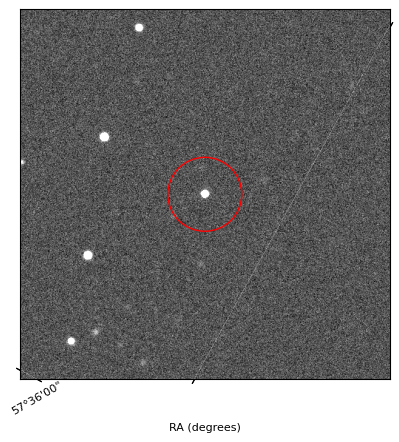

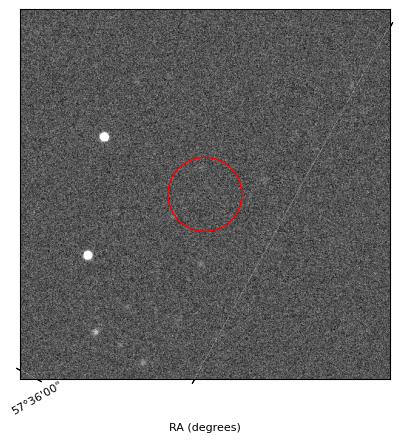

In [27]:
prob = problems[0]
cal = Calexp(prob[-1])
ax = cal.plot(roi = ((prob[3], prob[4]), 500))
cal.add_point(ax,prob[3], prob[4], r=50)
cal = prob[1]
ax = cal.plot(roi = ((prob[3], prob[4]), 500))
cal.add_point(ax,prob[3], prob[4], r=50)

In [28]:
prob

(2,
 LightCurve (57.578415312330364, -32.49397185072904) - Band y - Points: 3304,
 57.578415312330364,
 -32.49397185072904,
 <class 'lsst.afw.table.SourceCatalog'>
  id       coord_ra      ... base_InvalidPsf_flag
             rad         ...                     
 ---- ------------------ ... --------------------
    1 1.0088897906768026 ...                False
    2  1.008818632225597 ...                False
    3 1.0085732600771076 ...                False
    4 1.0078462747661923 ...                False
    5 1.0077030207433633 ...                False
    6 1.0079682194278483 ...                False
    7 1.0086718080242179 ...                False
    8  1.008381877044176 ...                False
    9 1.0087261537562802 ...                False
  ...                ... ...                  ...
 1324  1.004381500253881 ...                False
 1325  1.004560197933929 ...                False
 1326 1.0043398453871855 ...                False
 1327 1.0050215834618546 ...        

In [4]:
# process.find_flux(prob[4], prob[-5])
from lsst.geom import Angle, degrees, SpherePoint, radians
sources = prob[4]
injected_catalog = prob[-5]
injected_exposure = prob[-1]
id_near = np.argmin([SpherePoint(prob[2], prob[3], degrees).separation(SpherePoint(sources["coord_ra"][i],sources["coord_dec"][i], radians)) for i in range(len(sources))])
flux, flux_err =  sources["base_PsfFlux_instFlux"][id_near], sources["base_PsfFlux_instFluxErr"][id_near]
mag, mag_err = prob[1].get_mag(flux, flux_err)
print("pre injection", mag, mag_err)
mag, mag_err = Calexp(injected_exposure).get_mag(flux, flux_err)
print("after injection", mag, mag_err)

pre injection 16.99427739250537 0.0022409277509399077
after injection 16.99427739250537 0.0022409277509399077


In [7]:
from lsst.geom import Angle, degrees, SpherePoint, radians
print("el que salio mal:", Angle(0.0019295135800769558, degrees)>Angle(1e-6, radians))
print("uno que salio bien:", Angle(1.83125e-07, radians)>Angle(1e-6, radians))

el que salio mal: True
uno que salio bien: False


In [5]:
min([SpherePoint(prob[2], prob[3], degrees).separation(SpherePoint(sources["coord_ra"][i],sources["coord_dec"][i], radians)) for i in range(len(sources))])

Angle(2.2321320653693568e-07, degrees)

In [35]:
columns_flux = [col for col in list(sources.asAstropy().columns) if "Flux" in col and not "Err" in col and not "flag" in col]
for col_flux in columns_flux:
    try:        
        flux, flux_err =  sources[col_flux][id_near], sources[col_flux+"Err"][id_near]
        mag, mag_err = prob[1].get_mag(flux, flux_err)
        print(col_flux)
        print(mag, mag_err)
    except KeyError:
        pass
    

base_SdssShape_instFlux
23.46779113155412 0.09396156710670042
slot_Shape_instFlux
23.46779113155412 0.09396156710670042
base_CircularApertureFlux_3_0_instFlux
23.94344981441925 0.07001981722163395
base_CircularApertureFlux_4_5_instFlux
23.582268550344292 0.07327601075805719
base_CircularApertureFlux_6_0_instFlux
23.42564042287492 0.08358727851081908
base_CircularApertureFlux_9_0_instFlux
23.21879739821421 0.10255549581524982
base_CircularApertureFlux_12_0_instFlux
23.324241843597996 0.15104253222903496
slot_ApFlux_instFlux
23.324241843597996 0.15104253222903496
slot_CalibFlux_instFlux
23.324241843597996 0.15104253222903496
base_CircularApertureFlux_17_0_instFlux
23.30936601154571 0.21006638257922858
base_CircularApertureFlux_25_0_instFlux
23.41926051042695 0.3405288491380355
base_CircularApertureFlux_35_0_instFlux
23.45104971521842 0.4917472495401358
base_CircularApertureFlux_50_0_instFlux
23.402111728200126 0.6718605156458649
base_CircularApertureFlux_70_0_instFlux
22.444543666403206 

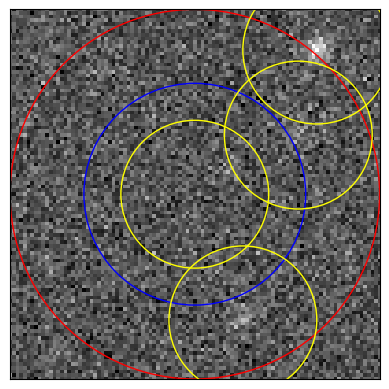

In [6]:
cal = prob[1]
ax = cal.plot(roi = ((prob[2], prob[3]), 100))
cal.add_point(ax,prob[2], prob[3], r=50)
cal.add_point(ax,Angle(sources["coord_ra"][id_near], radians).asDegrees(), Angle(sources["coord_dec"][id_near], radians).asDegrees(), r=30, c="blue")
for source in sources:
    cal.add_point(ax,Angle(source["coord_ra"], radians).asDegrees(), Angle(source["coord_dec"], radians).asDegrees(), r=20, c="yellow")

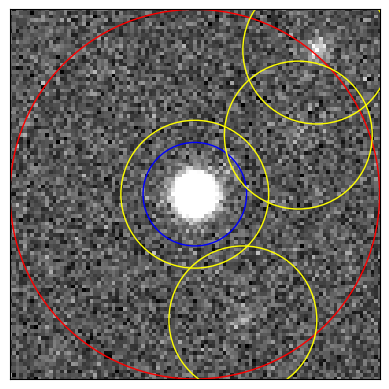

In [8]:
cal = Calexp(prob[-1])
ax = cal.plot(roi = ((prob[2], prob[3]), 100))
cal.add_point(ax,prob[2], prob[3], r=50)
cal.add_point(ax,Angle(sources["coord_ra"][id_near], radians).asDegrees(), Angle(sources["coord_dec"][id_near], radians).asDegrees(), r=28/2, c="blue")
for source in sources:
    cal.add_point(ax,Angle(source["coord_ra"], radians).asDegrees(), Angle(source["coord_dec"], radians).asDegrees(), r=20, c="yellow")

In [ ]:
if

In [23]:
columns_flux, columns_err

(['base_Blendedness_raw_child_instFlux',
  'base_Blendedness_raw_parent_instFlux',
  'base_Blendedness_abs_child_instFlux',
  'base_Blendedness_abs_parent_instFlux',
  'base_SdssShape_instFlux',
  'slot_Shape_instFlux',
  'base_SdssShape_instFlux_xx_Cov',
  'slot_Shape_instFlux_xx_Cov',
  'base_SdssShape_instFlux_yy_Cov',
  'slot_Shape_instFlux_yy_Cov',
  'base_SdssShape_instFlux_xy_Cov',
  'slot_Shape_instFlux_xy_Cov',
  'base_CircularApertureFlux_3_0_instFlux',
  'base_CircularApertureFlux_4_5_instFlux',
  'base_CircularApertureFlux_6_0_instFlux',
  'base_CircularApertureFlux_9_0_instFlux',
  'base_CircularApertureFlux_12_0_instFlux',
  'slot_ApFlux_instFlux',
  'slot_CalibFlux_instFlux',
  'base_CircularApertureFlux_17_0_instFlux',
  'base_CircularApertureFlux_25_0_instFlux',
  'base_CircularApertureFlux_35_0_instFlux',
  'base_CircularApertureFlux_50_0_instFlux',
  'base_CircularApertureFlux_70_0_instFlux',
  'base_CompensatedTophatFlux_12_instFlux',
  'base_CompensatedTophatFlux_1

In [ ]:
vv =[cal.get_mag(flux, flux_err) for flux, flux_err in zip(sources["base_PsfFlux_instFlux"], sources["base_PsfFlux_instFluxErr"])]

In [ ]:
# for i, (f, ferr) in enumerate(zip(flux, flux_err)):
    if f is not np.nan:
        mag, mag_err = calexp.get_mag(f, ferr)
        print("calexp: Measured ", mag, mag_err)
        mag, mag_err = inj_calexp.get_mag(f, ferr)
        print("inj_calexp: Measured ", mag, mag_err)
        print("Injected ", lc.data["mag_sim"][idx])

In [13]:
flux

[469431.379372342,
 nan,
 nan,
 nan,
 40407.3056863535,
 nan,
 nan,
 6639.260347354422,
 nan,
 6095.278455285252]

||||||||||||||----------- POINT: 50 ------ LEVEL: 9 -----------||||||||||||||
(ra,dec) = (57.59451632893858, -32.481152201226145)
HTM_ID = 2353633 - HTM_level=9 (bounded by a circle of radius ~561.27 arcsec.)


/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/share/eups/Linux64/daf_butler/g812ef82787+d5e7d2ce4b/python/lsst/daf/butler/registry/queries/_structs.py:401: FutureWarning: Dimension 'htm20' should no longer be used in data IDs. Use the region 'OVERLAPS' operator in the where clause instead. Will be removed after v28.
  warnings.warn(


Found 514 calexps


/home/karennowo/DP0_microlensing/light_curves.py:124: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, new_data_filtered], ignore_index=True)


 ------ CALEXP 1/10 ------
Points injected: 2
[10, 37]


Searching in lc 10
Searching in lc 37
ra = 57.54856374440088, dec = -32.672283712542615
Measured  19.222914813479196 0.005872746949709428
Injected  19.224290195098348
ra = 57.5238573093214, dec = -32.65873030510227
Measured  22.501706256835273 0.07450376618500265
Injected  22.53041264407794
 ------ CALEXP 2/10 ------
Points injected: 40
[0, 1, 3, 4, 5, 6, 7, 8, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49]


Searching in lc 0
Searching in lc 1
Searching in lc 3
Searching in lc 4
Searching in lc 5
Searching in lc 6
Searching in lc 7
Searching in lc 8
Searching in lc 11
Searching in lc 13
Searching in lc 15
Searching in lc 16
Searching in lc 17
Searching in lc 18
Searching in lc 19
Searching in lc 20
Searching in lc 21
Searching in lc 22
Searching in lc 23
Searching in lc 24
Searching in lc 25
Searching in lc 26
Searching in lc 27
Searching in lc 28
Searching in lc 29
Searching in lc 31
Searching in lc 33
Searching in lc 34
Searching in lc 35
Searching in lc 36
Searching in lc 38
Searching in lc 41
Searching in lc 42
Searching in lc 43
Searching in lc 44
Searching in lc 45
Searching in lc 46
Searching in lc 47
Searching in lc 48
Searching in lc 49
ra = 57.59451632893858, dec = -32.481152201226145
Measured  17.994147885869737 0.0029192126371771986
Injected  17.999800399179982
ra = 57.62069358964389, dec = -32.637404611605604
Measured  18.11694144469525 0.0031200636540546015
Injected  18.12224

Searching in lc 2
Searching in lc 9
Searching in lc 10
Searching in lc 12
Searching in lc 14
Searching in lc 18
Searching in lc 22
Searching in lc 32
Searching in lc 37
Searching in lc 39
Searching in lc 40
ra = 57.50562978570095, dec = -32.64848910394702
Measured  18.23195299652733 0.0033920238389218583
Injected  18.244424459038253
ra = 57.50176964817662, dec = -32.650050826181044
Measured  19.09372034299661 0.005675824029410904
Injected  19.101567316181107
ra = 57.54856374440088, dec = -32.672283712542615
Measured  19.20734232670568 0.006122585196165755
Injected  19.224016295772945
ra = 57.50260290504448, dec = -32.648282998240724
Measured  19.4592400787533 0.007236558614661087
Injected  19.46891425495662
ra = 57.48591383505169, dec = -32.67266564816517
Measured  19.712923836359565 0.00862797521406421
Injected  19.713812214140294
ra = 57.5420984482355, dec = -32.628960709340554
Measured  20.203353892812817 0.012319583422777237
Injected  20.20360813250764
ra = 57.54996685473852, dec =

Searching in lc 1
Searching in lc 4
Searching in lc 7
Searching in lc 11
Searching in lc 21
Searching in lc 23
Searching in lc 38
Searching in lc 43
Searching in lc 45
Searching in lc 46
ra = 57.62069358964389, dec = -32.637404611605604
Measured  18.12049820168802 0.003190601441225655
Injected  18.121975479446416
ra = 57.65619144708684, dec = -32.670686770763616
Measured  18.484947227730707 0.003918831069513166
Injected  18.489322418221924
ra = 57.602782281878554, dec = -32.64458501715527
Measured  18.842999589881785 0.0048583516142788755
Injected  18.856669356997436
ra = 57.625969352314506, dec = -32.642555069726214
Measured  19.329215552180166 0.006624205204266497
Injected  19.346465275364782
ra = 57.69732847482308, dec = -32.65039600467563
Measured  22.153503173176397 0.06155367990250683
Injected  20.570955071283148
ra = 57.760519965358306, dec = -32.666483722841676
Measured  23.294236151283112 0.17144805464025922
Injected  20.815853030466823
ra = 57.666727345536714, dec = -32.67384

Loading calexps: 100%|██████████| 514/514 [19:01<00:00,  2.22s/it]


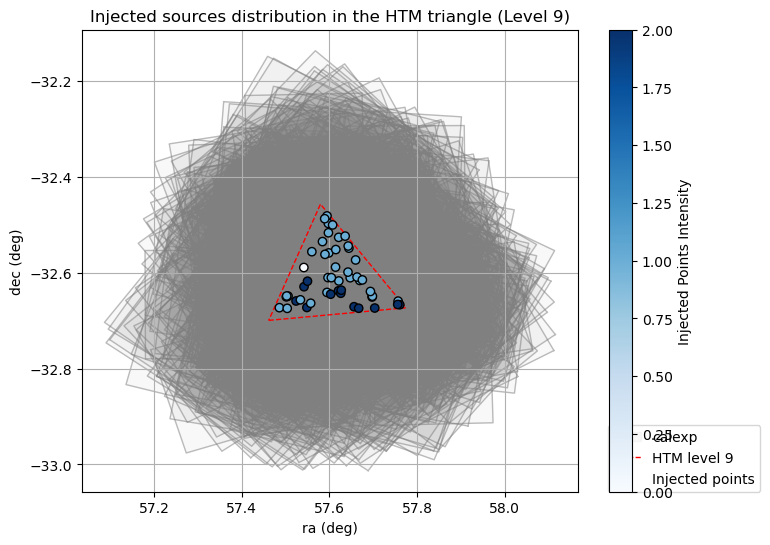

||||||||||||||----------- POINT: 50 ------ LEVEL: 10 -----------||||||||||||||
(ra,dec) = (57.59451632893858, -32.481152201226145)
HTM_ID = 9414534 - HTM_level=10 (bounded by a circle of radius ~280.63 arcsec.)


/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/share/eups/Linux64/daf_butler/g812ef82787+d5e7d2ce4b/python/lsst/daf/butler/registry/queries/_structs.py:401: FutureWarning: Dimension 'htm20' should no longer be used in data IDs. Use the region 'OVERLAPS' operator in the where clause instead. Will be removed after v28.
  warnings.warn(


Found 313 calexps


/home/karennowo/DP0_microlensing/light_curves.py:124: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, new_data_filtered], ignore_index=True)


 ------ CALEXP 1/10 ------
Points injected: 37
[0, 1, 2, 3, 4, 5, 8, 10, 12, 13, 14, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 40, 41, 42, 43, 44, 45, 48, 49]


Searching in lc 0
Searching in lc 1
Searching in lc 2
Searching in lc 3
Searching in lc 4
Searching in lc 5
Searching in lc 8
Searching in lc 10
Searching in lc 12
Searching in lc 13
Searching in lc 14
Searching in lc 16
Searching in lc 18
Searching in lc 19
Searching in lc 21
Searching in lc 22
Searching in lc 23
Searching in lc 24
Searching in lc 25
Searching in lc 26
Searching in lc 27
Searching in lc 28
Searching in lc 29
Searching in lc 30
Searching in lc 32
Searching in lc 33
Searching in lc 34
Searching in lc 36
Searching in lc 37
Searching in lc 40
Searching in lc 41
Searching in lc 42
Searching in lc 43
Searching in lc 44
Searching in lc 45
Searching in lc 48
Searching in lc 49
ra = 57.59451632893858, dec = -32.481152201226145
Measured  17.994321805644834 0.0029193834878855868
Injected  17.999800399179982
ra = 57.642449626863595, dec = -32.528778228304276
Measured  18.119950144765028 0.0031173663469491212
Injected  18.12224937877182
ra = 57.61497025995724, dec = -32.5586064127

Searching in lc 0
Searching in lc 1
Searching in lc 2
Searching in lc 3
Searching in lc 4
Searching in lc 5
Searching in lc 6
Searching in lc 7
Searching in lc 8
Searching in lc 9
Searching in lc 11
Searching in lc 12
Searching in lc 13
Searching in lc 14
Searching in lc 15
Searching in lc 16
Searching in lc 17
Searching in lc 18
Searching in lc 19
Searching in lc 20
Searching in lc 21
Searching in lc 22
Searching in lc 23
Searching in lc 24
Searching in lc 25
Searching in lc 26
Searching in lc 27
Searching in lc 28
Searching in lc 29
Searching in lc 30
Searching in lc 33
Searching in lc 34
Searching in lc 35
Searching in lc 36
Searching in lc 37
Searching in lc 38
Searching in lc 39
Searching in lc 40
Searching in lc 41
Searching in lc 42
Searching in lc 43
Searching in lc 44
Searching in lc 45
Searching in lc 46
Searching in lc 47
Searching in lc 48
Searching in lc 49
ra = 57.59451632893858, dec = -32.481152201226145
Measured  17.996999024786266 0.0028472018252343034
Injected  17.999

Searching in lc 1
Searching in lc 4
Searching in lc 10
Searching in lc 16
Searching in lc 21
Searching in lc 23
Searching in lc 26
Searching in lc 28
Searching in lc 32
Searching in lc 33
Searching in lc 36
Searching in lc 37
Searching in lc 40
ra = 57.642449626863595, dec = -32.528778228304276
Measured  18.120655816195054 0.0030403256438734116
Injected  18.121975430144985
ra = 57.62507957213043, dec = -32.54047556828128
Measured  18.487568142717915 0.003692680323440165
Injected  18.489322368920494
ra = 57.65546972705306, dec = -32.565209837573605
Measured  19.224264741452238 0.005586262193894199
Injected  19.224016246471514
ra = 57.635082998062245, dec = -32.54861914969935
Measured  19.9616519132696 0.008944834903753012
Injected  19.958710124022534
ra = 57.641885074952185, dec = -32.541696617862684
Measured  20.5684113930279 0.013688985332089202
Injected  20.570955021981717
ra = 57.62870587387553, dec = -32.51586083901543
Measured  20.801332329184937 0.016322077271657076
Injected  20.

Loading calexps: 100%|██████████| 313/313 [11:10<00:00,  2.14s/it]


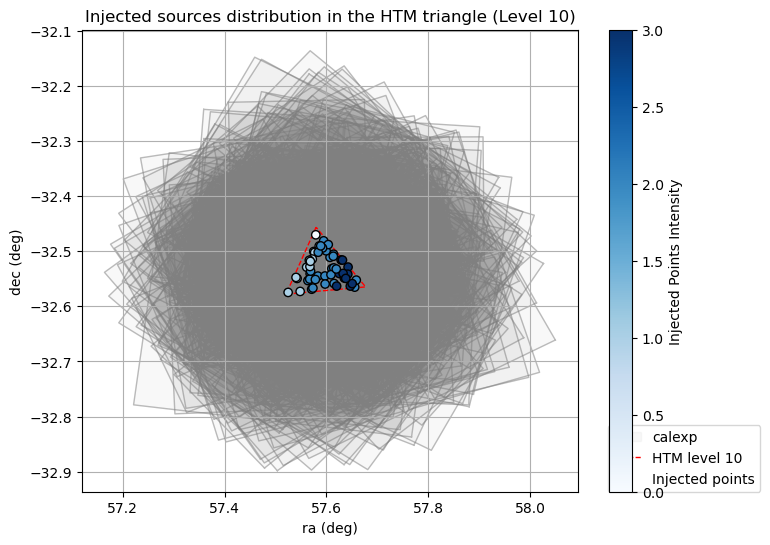

||||||||||||||----------- POINT: 50 ------ LEVEL: 11 -----------||||||||||||||
(ra,dec) = (57.59451632893858, -32.481152201226145)
HTM_ID = 37658136 - HTM_level=11 (bounded by a circle of radius ~140.32 arcsec.)


/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/share/eups/Linux64/daf_butler/g812ef82787+d5e7d2ce4b/python/lsst/daf/butler/registry/queries/_structs.py:401: FutureWarning: Dimension 'htm20' should no longer be used in data IDs. Use the region 'OVERLAPS' operator in the where clause instead. Will be removed after v28.
  warnings.warn(


Found 229 calexps


/home/karennowo/DP0_microlensing/light_curves.py:124: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, new_data_filtered], ignore_index=True)


 ------ CALEXP 1/10 ------
Points injected: 26
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 18, 20, 22, 23, 26, 27, 34, 36, 42, 43, 44, 46, 47, 49]


Searching in lc 0
Searching in lc 1
Searching in lc 2
Searching in lc 3
Searching in lc 4
Searching in lc 5
Searching in lc 6
Searching in lc 7
Searching in lc 8
Searching in lc 9
Searching in lc 13
Searching in lc 14
Searching in lc 18
Searching in lc 20
Searching in lc 22
Searching in lc 23
Searching in lc 26
Searching in lc 27
Searching in lc 34
Searching in lc 36
Searching in lc 42
Searching in lc 43
Searching in lc 44
Searching in lc 46
Searching in lc 47
Searching in lc 49
ra = 57.59451632893858, dec = -32.481152201226145
Measured  17.997752815681736 0.0029239089745770603
Injected  17.999800399179982
ra = 57.6205891225065, dec = -32.5056507309698
Measured  18.119329266351723 0.0031183924424742085
Injected  18.12224937877182
ra = 57.58338328444613, dec = -32.50866406021413
Measured  18.234559766962203 0.003313341402542067
Injected  18.244698358363657
ra = 57.593529281681555, dec = -32.489286751050805
Measured  18.362580305301837 0.0035523276293113245
Injected  18.367147337955494
r

Searching in lc 0
Searching in lc 1
Searching in lc 2
Searching in lc 3
Searching in lc 4
Searching in lc 5
Searching in lc 6
Searching in lc 7
Searching in lc 8
Searching in lc 9
Searching in lc 10
Searching in lc 11
Searching in lc 12
Searching in lc 13
Searching in lc 14
Searching in lc 15
Searching in lc 16
Searching in lc 17
Searching in lc 18
Searching in lc 19
Searching in lc 20
Searching in lc 21
Searching in lc 22
Searching in lc 23
Searching in lc 24
Searching in lc 25
Searching in lc 26
Searching in lc 27
Searching in lc 28
Searching in lc 30
Searching in lc 31
Searching in lc 32
Searching in lc 33
Searching in lc 34
Searching in lc 36
Searching in lc 37
Searching in lc 38
Searching in lc 39
Searching in lc 40
Searching in lc 41
Searching in lc 42
Searching in lc 43
Searching in lc 44
Searching in lc 45
Searching in lc 46
Searching in lc 47
Searching in lc 48
Searching in lc 49
ra = 57.59451632893858, dec = -32.481152201226145
Measured  17.99812038559415 0.002847415168836372

Searching in lc 0
Searching in lc 1
Searching in lc 2
Searching in lc 3
Searching in lc 4
Searching in lc 5
Searching in lc 6
Searching in lc 7
Searching in lc 8
Searching in lc 9
Searching in lc 10
Searching in lc 11
Searching in lc 13
Searching in lc 14
Searching in lc 15
Searching in lc 17
Searching in lc 18
Searching in lc 19
Searching in lc 20
Searching in lc 22
Searching in lc 23
Searching in lc 24
Searching in lc 25
Searching in lc 26
Searching in lc 27
Searching in lc 30
Searching in lc 31
Searching in lc 32
Searching in lc 33
Searching in lc 34
Searching in lc 36
Searching in lc 37
Searching in lc 38
Searching in lc 39
Searching in lc 40
Searching in lc 42
Searching in lc 43
Searching in lc 44
Searching in lc 45
Searching in lc 46
Searching in lc 47
Searching in lc 48
Searching in lc 49
ra = 57.59451632893858, dec = -32.481152201226145
Measured  18.00083097451195 0.002806669757932251
Injected  17.999520247493123
ra = 57.6205891225065, dec = -32.5056507309698
Measured  18.12006

Loading calexps:  24%|██▎       | 54/229 [01:50<05:59,  2.06s/it]


KeyboardInterrupt: 

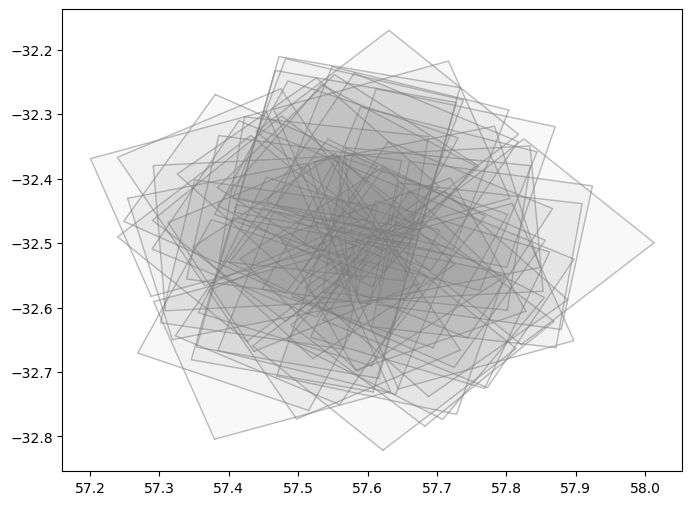

In [109]:
n_points = [50,100,150]
levels = [9,10,11,12]
problems = []
# start = False
for n in n_points:
    for lvl in levels:
        # if n==70 and lvl==11:
        #     start=True
        # if start:
        print(f"||||||||||||||----------- POINT: {n} ------ LEVEL: {lvl} -----------||||||||||||||")
        process = Run(name = f"run_{n}pts_{lvl}lvl", htm_level=lvl)
        process.inject_task()
        schema = process.measure_task()
        params = [{"t_0": 60700.5, "t_E": 110, "u_0": 0.5, "m_base": m} for m in np.linspace(18,24,n)]
        process.add_lc(params[0], ra=57.59451632893858, dec=-32.481152201226145)
        for p in params[1:]:
            process.add_lc(p, dist=0.00000001)
        # process.sky_map(calexps=False)
        process.log_task("Add and simulate light curves")
        for j, dataId in enumerate(process.calexp_dataIds[:5]):
            print(f" ------ CALEXP {j+1}/10 ------")
            calexp = Calexp(dataId)
            # ax = calexp.plot() # plotear cada calexp con los puntos a inyectar y chequear si efectivamente contiene la cantidad que la funcion de inyeccion dice que contiene
            injected_exp, injected_points = process.inject_calexp(calexp, save_fit=f"calexp_{j}.fit")
            if injected_exp != None:
                sources = process.measure_calexp(injected_exp, schema)
                flux, flux_err = process.find_flux(sources, injected_points, save=dataId)
                for f, ferr, lc_idx in zip(flux, flux_err, injected_points):
                    lc = process.inj_lc[lc_idx]
                    mag, mag_err = calexp.get_mag(f, ferr)
                    lc.add_mag(mag, mag_err, dataId)
                    print(f"ra = {lc.ra}, dec = {lc.dec}")
                    print("Measured ", mag, mag_err)
                    print("Injected ", lc.data["mag_sim"][j])
        process.save_lc()
        process.sky_map()
    


### Run results

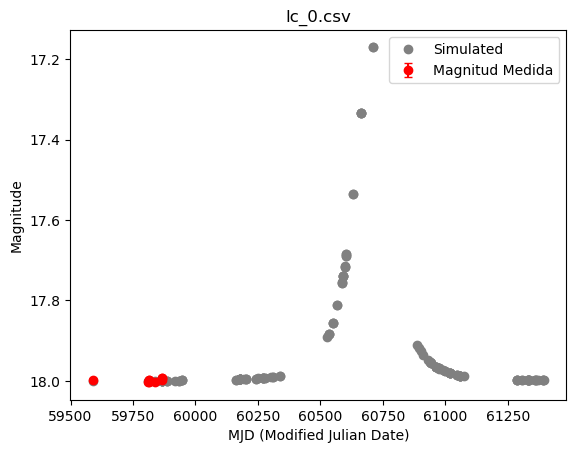

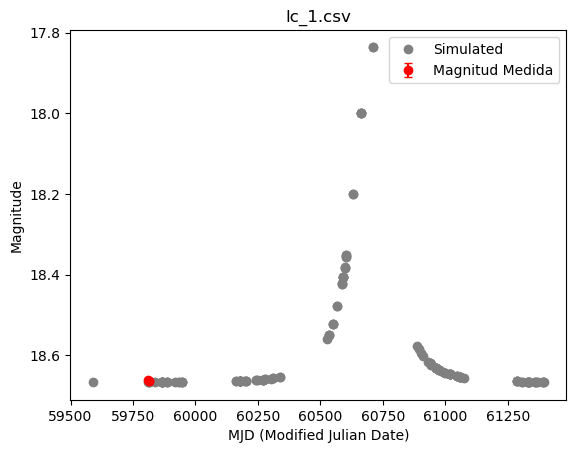

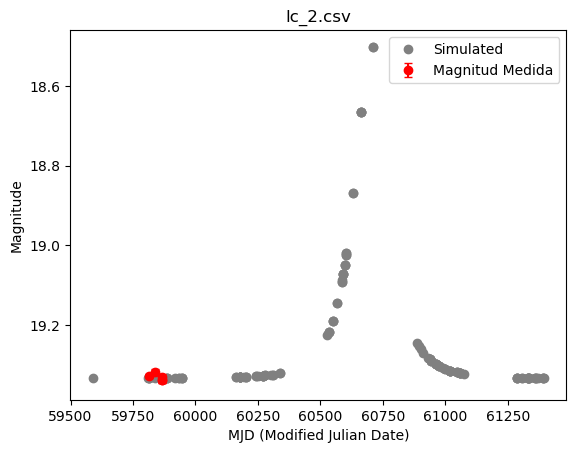

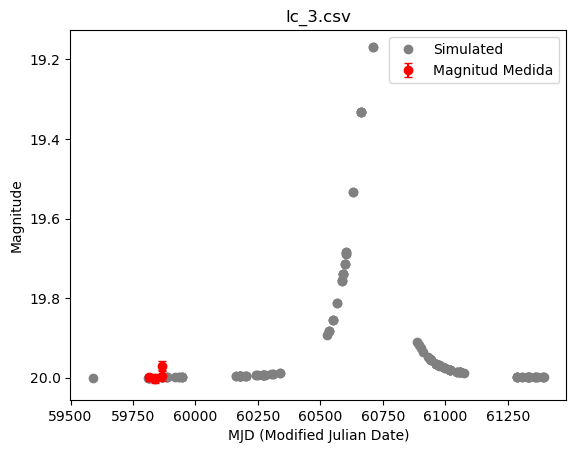

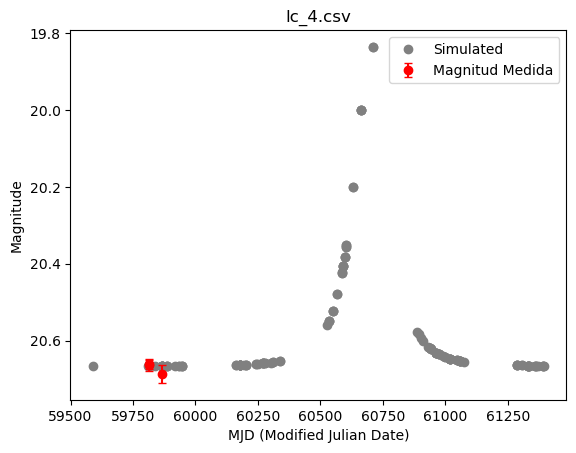

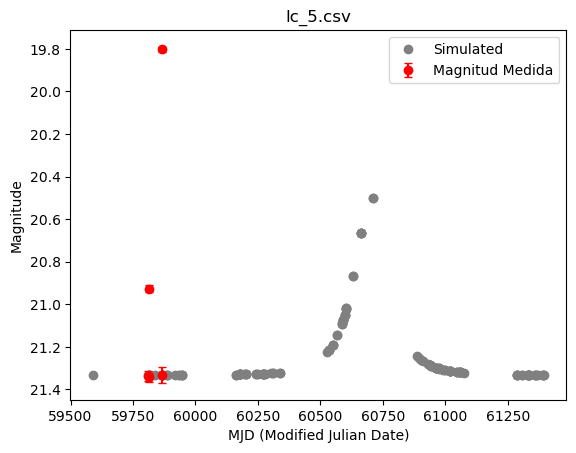

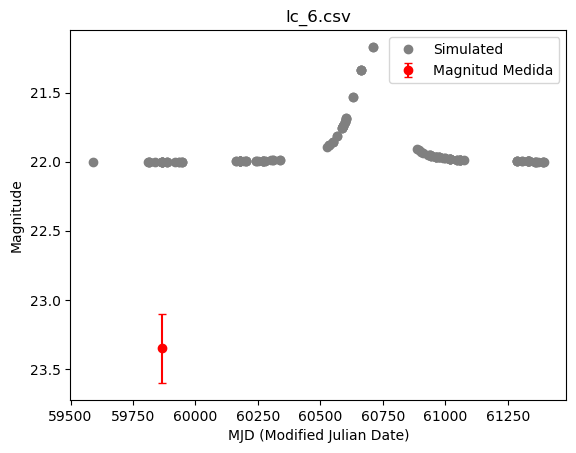

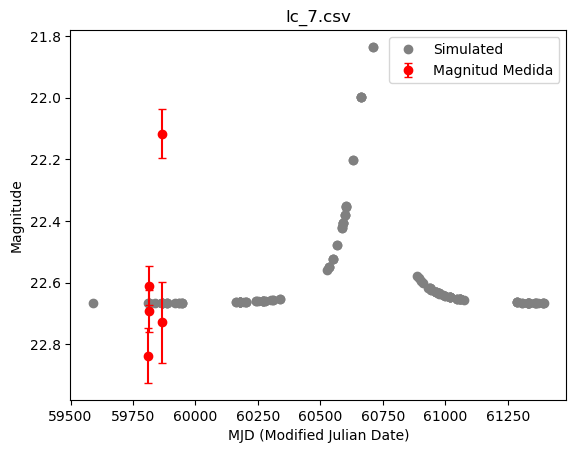

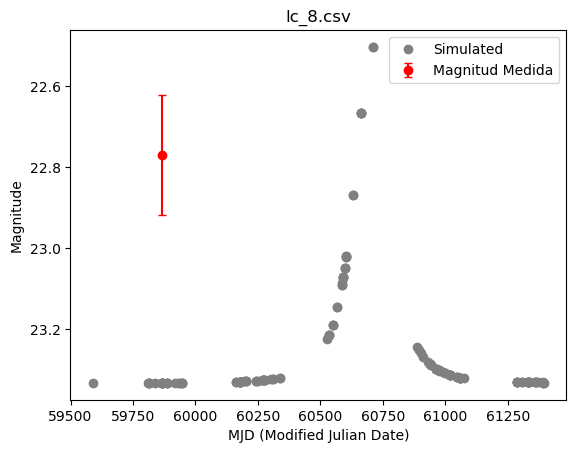

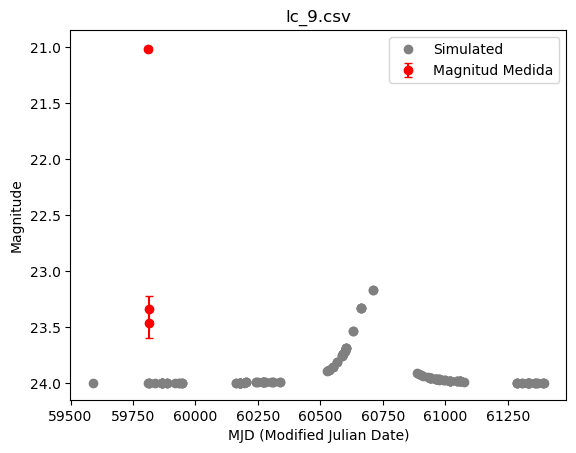

In [3]:
# Plot light curves from a run
import pandas as pd
n=10; lvl = 20
path = f"runs/run_{n}pts_{lvl}lvl/"
for lc_path in sorted([file for file in os.listdir(path) if file.startswith("lc")]):
    lc = LightCurve(data=pd.read_csv(path+lc_path))
    lc.plot(title = lc_path)


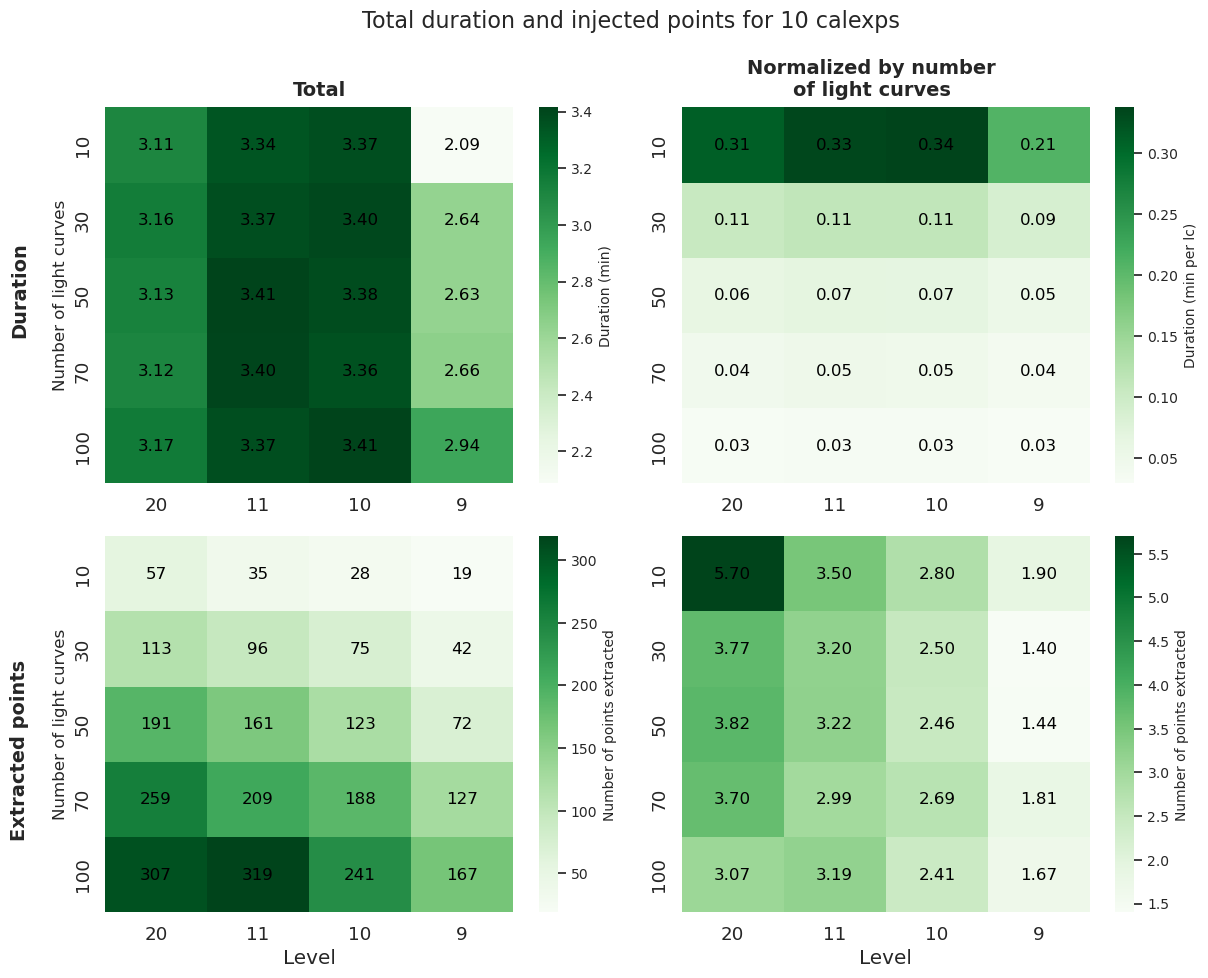

In [132]:
# Total durations and total extracted points per HTM level and points injected
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.2)


fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 
fig.suptitle("Total duration and injected points for 10 calexps", fontsize=16) 

# Gráfico 1: Duration
sns.heatmap(durations, cmap='Greens', annot=True, fmt=".2f", 
            xticklabels=levels, yticklabels=n_points, 
            annot_kws={'size': 12, 'color': 'black'}, ax=axes[0, 0])
cbar = axes[0, 0].collections[0].colorbar
cbar.ax.tick_params(labelsize=10)  
cbar.set_label('Duration (min)', fontsize=10)  
axes[0, 0].set_ylabel('Number of light curves', fontsize=12)
# axes[0, 0].set_title('Duration')

# Gráfico 2: Duration - Normalized
sns.heatmap(durations_normalized, cmap='Greens', annot=True, fmt=".2f", 
            xticklabels=levels, yticklabels=n_points, 
            annot_kws={'size': 12, 'color': 'black'}, ax=axes[0, 1])
cbar = axes[0, 1].collections[0].colorbar
cbar.ax.tick_params(labelsize=10) 
cbar.set_label('Duration (min per lc)', fontsize=10)  # Ajustar el tamaño de la etiqueta del colorbar
# axes[0, 1].set_title('Duration - Normalized')

# Gráfico 3: Injected points
sns.heatmap(points, cmap='Greens', annot=True, fmt=".0f", 
            xticklabels=levels, yticklabels=n_points, 
            cbar_kws={'label': 'Number of points injected'}, 
            annot_kws={'size': 12, 'color': 'black'}, ax=axes[1, 0])
cbar = axes[1, 0].collections[0].colorbar
cbar.ax.tick_params(labelsize=10)  # Ajustar el tamaño de los ticks
cbar.set_label('Number of points extracted', fontsize=10)  # Ajustar el tamaño de la etiqueta del colorbar
axes[1, 0].set_xlabel('Level')
axes[1, 0].set_ylabel('Number of light curves', fontsize=12)
# axes[1, 0].set_title('Injected points')

# Gráfico 4: Injected points - Normalized
sns.heatmap(points_normalized, cmap='Greens', annot=True, fmt=".2f", 
            xticklabels=levels, yticklabels=n_points, 
            cbar_kws={'label': 'Number of points injected'}, 
            annot_kws={'size': 12, 'color': 'black'}, ax=axes[1, 1])
cbar = axes[1, 1].collections[0].colorbar
cbar.ax.tick_params(labelsize=10)  # Ajustar el tamaño de los ticks
cbar.set_label('Number of points extracted', fontsize=10)  # Ajustar el tamaño de la etiqueta del colorbar
axes[1, 1].set_xlabel('Level')
# axes[1, 1].set_title('Injected points - Normalized')

# Etiquetas de las filas y columnas
fig.text(0.24, 0.9, 'Total', ha='center', va='center', fontsize=14, fontweight='bold')
fig.text(0.7, 0.91, 'Normalized by number\nof light curves', ha='center', va='center', fontsize=14, fontweight='bold')

fig.text(-0.01, 0.7, 'Duration', ha='center', va='center', fontsize=14, fontweight='bold', rotation='vertical')
fig.text(-0.01, 0.24, 'Extracted points', ha='center', va='center', fontsize=14, fontweight='bold', rotation='vertical')

# Ajustar diseño para evitar superposición
plt.tight_layout(rect=[0, 0, 1, 0.95])  # rect ajusta el espacio para el título general
plt.savefig('runs/test_10_calexps/comparative_analysis.png', bbox_inches='tight')  # Guardar la figura combinada
plt.show()


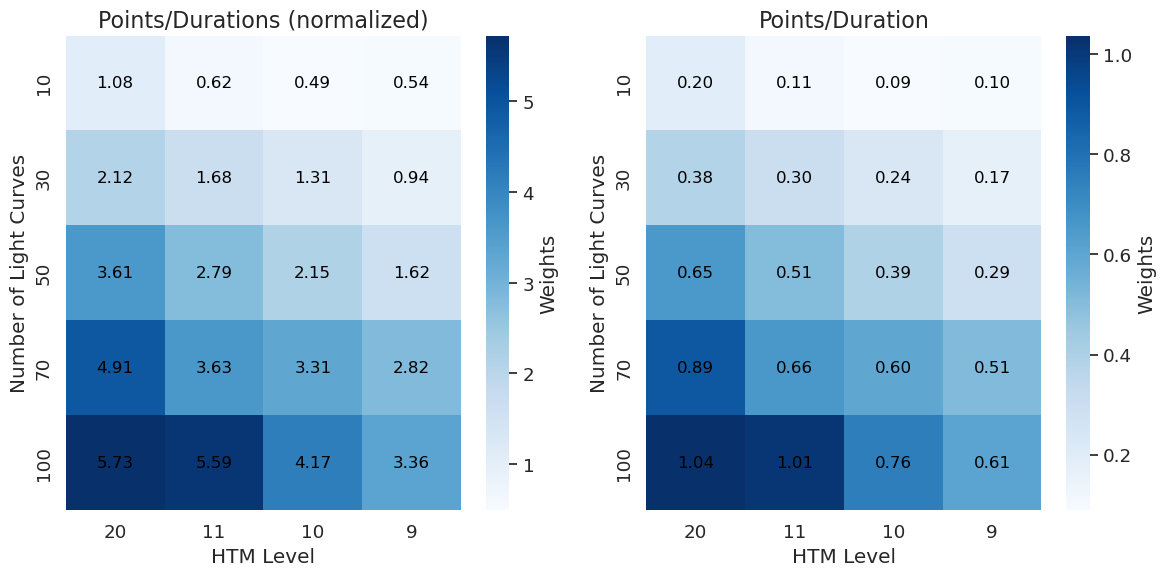

In [144]:
# Optimization index: maximize [extracted_points]/[duration]
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

n_points = [10, 30, 50, 70, 100]
levels = [20, 11, 10, 9]
durations = np.zeros((len(n_points), len(levels)))
durations_normalized = np.zeros((len(n_points), len(levels)))
points = np.zeros((len(n_points), len(levels)))
points_normalized = np.zeros((len(n_points), len(levels)))
weights = np.zeros((len(n_points), len(levels)))

for i, n in enumerate(n_points):
    for j, lvl in enumerate(levels):
        time_path = f"runs/test_10_calexps/run_{n}pts_{lvl}lvl/time_log.csv"
        df = pd.read_csv(time_path)
        points[i, j] = sum(df[df["task"] == "Finding points"]["detail"])
        points_normalized[i, j] = sum(df[df["task"] == "Finding points"]["detail"]) / n
        times = df["time"].values
        total_duration = times[-1] - times[1]
        durations[i, j] = total_duration / 60
        durations_normalized[i, j] = (total_duration / 60) / n

weights_1 = (points_normalized / np.max(points_normalized)) / (durations_normalized / np.max(durations_normalized))
weights_2 = (points / np.max(points)) / (durations / np.max(durations))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(weights_1, cmap='Blues', annot=True, fmt=".2f", 
            xticklabels=levels, yticklabels=n_points, 
            cbar_kws={'label': 'Weights'}, annot_kws={'size': 12, 'color': 'black'}, ax=axes[0])
axes[0].set_xlabel('HTM Level')
axes[0].set_ylabel('Number of Light Curves')
axes[0].set_title('Points/Durations (normalized)', fontsize=16)

sns.heatmap(weights_2, cmap='Blues', annot=True, fmt=".2f", 
            xticklabels=levels, yticklabels=n_points, 
            cbar_kws={'label': 'Weights'}, annot_kws={'size': 12, 'color': 'black'}, ax=axes[1])
axes[1].set_xlabel('HTM Level')
axes[1].set_ylabel('Number of Light Curves')
axes[1].set_title('Points/Duration', fontsize=16)

plt.tight_layout()
plt.savefig('runs/test_10_calexps/optimization_analysis_combined.png', bbox_inches='tight')
plt.show()


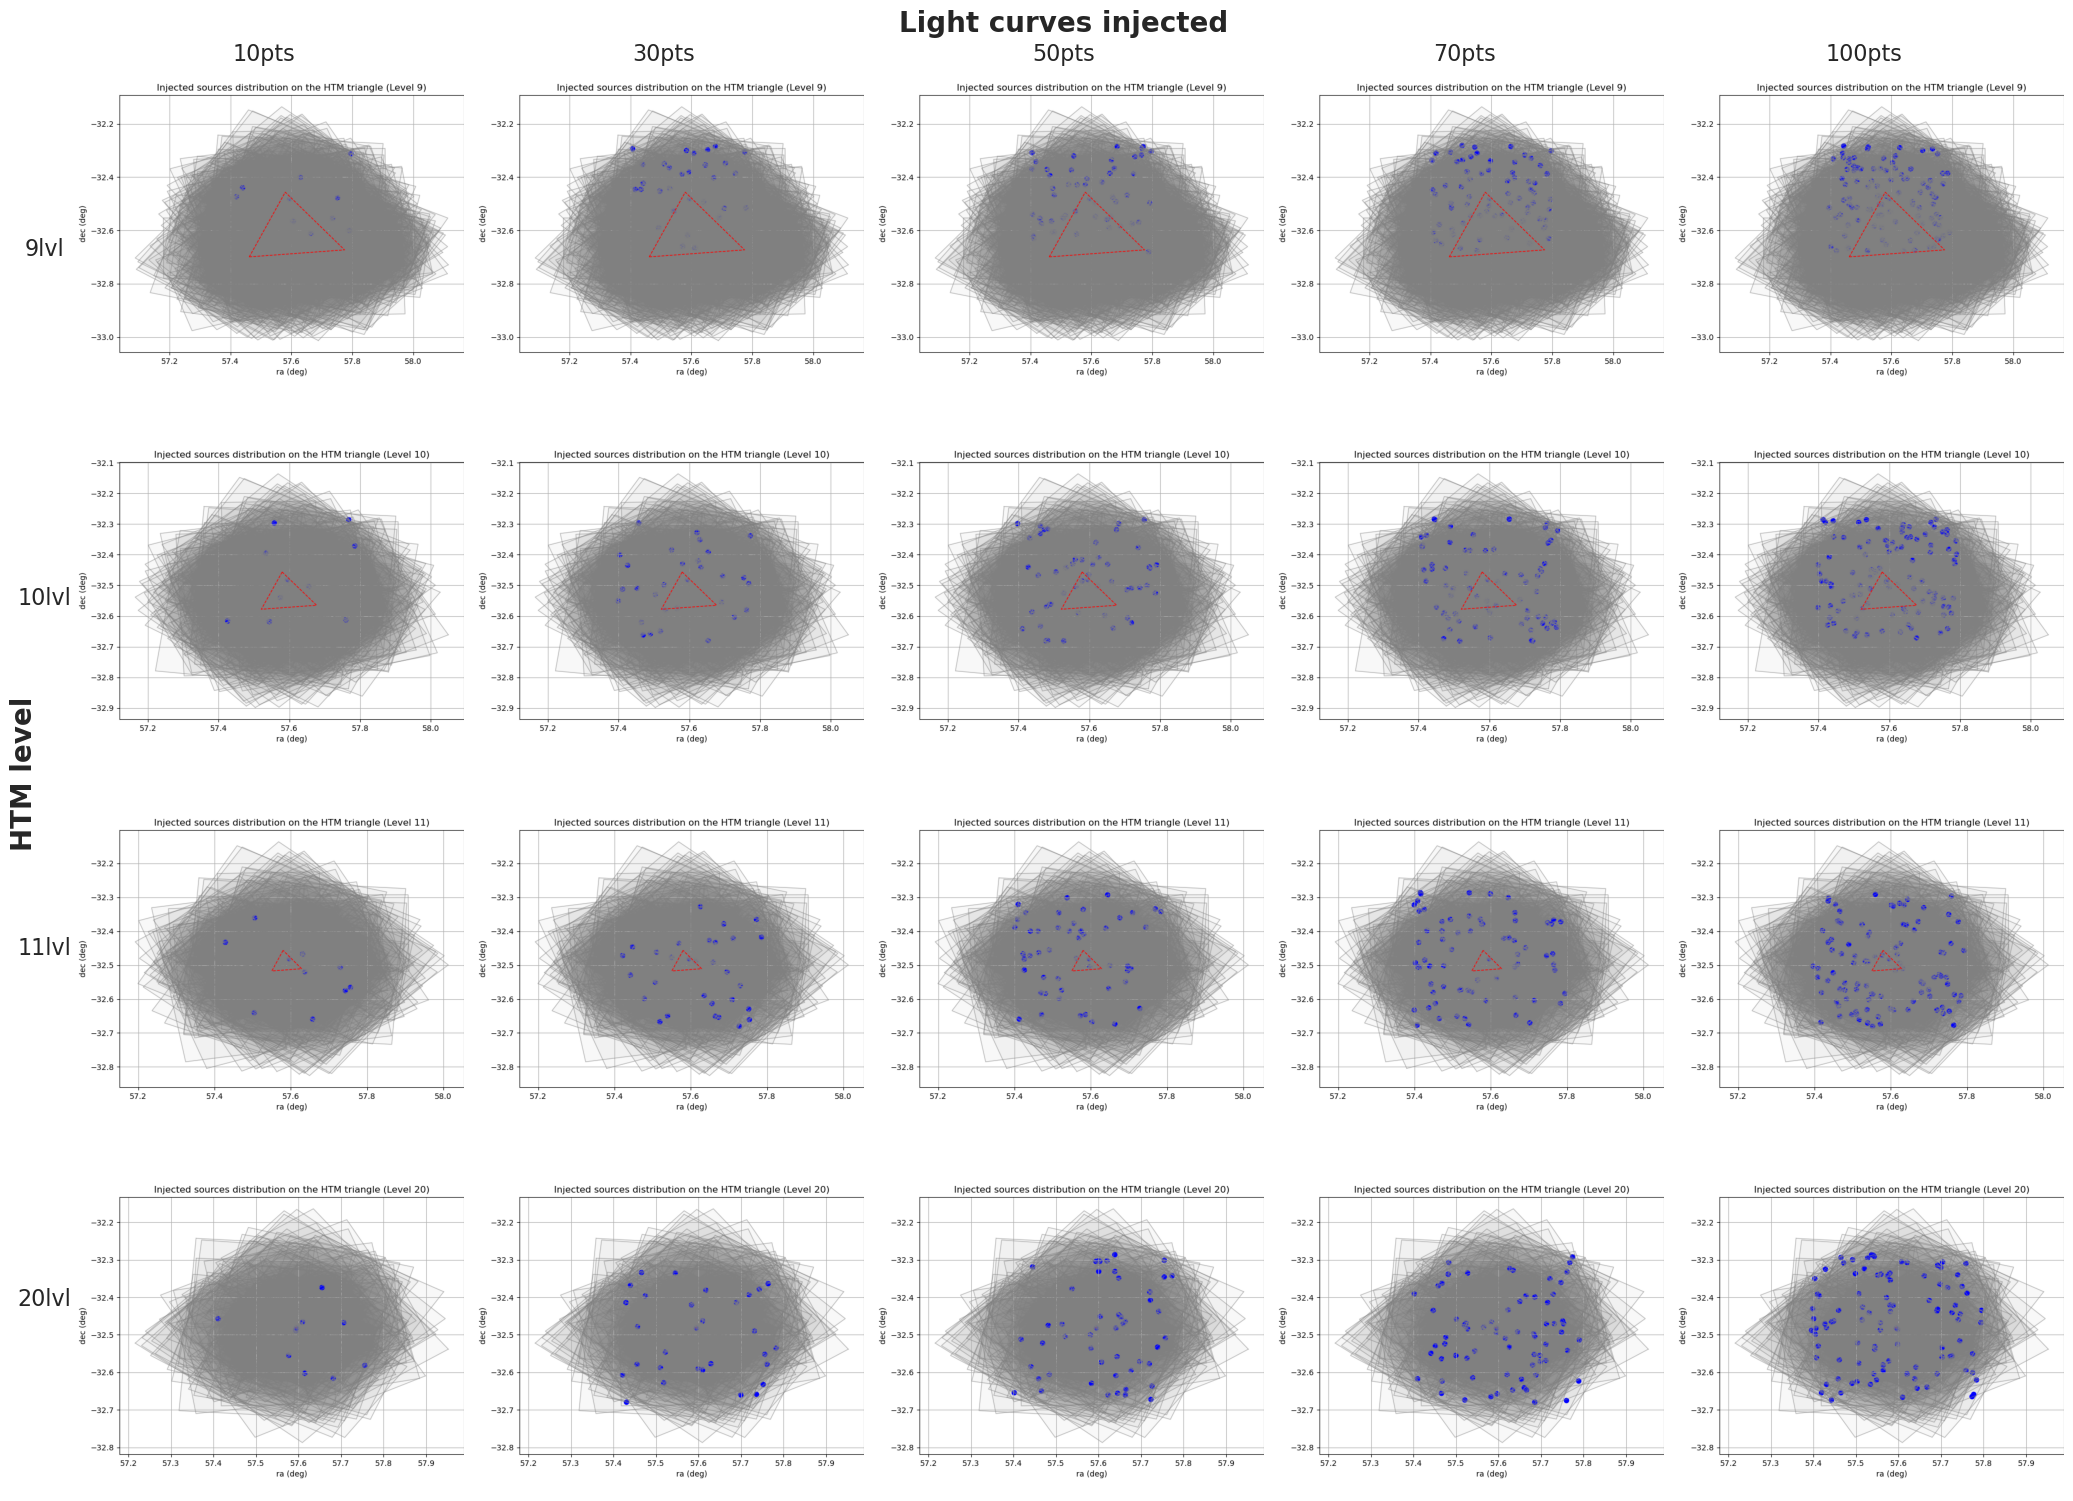

In [133]:
# Sky plots of injected sources + HTM triangle + calexps (for each combination of lvl and n_lc
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

main_folder = "runs/test_10_calexps"
pattern = r"run_(\d+)pts_(\d+)lvl"

plots = []
pts_values = []
lvl_values = []

for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):
        match = re.match(pattern, subfolder)
        if match:
            pts, lvl = match.groups()
            pts_values.append(int(pts))
            lvl_values.append(int(lvl))
            
            sky_map_path = os.path.join(subfolder_path, "sky_map.png")
            if os.path.exists(sky_map_path):
                plots.append(sky_map_path)

unique_pts = sorted(set(pts_values))  
unique_lvl = sorted(set(lvl_values)) 


fig, axes = plt.subplots(len(unique_lvl), len(unique_pts), figsize=(20, 15))
axes = axes.reshape((len(unique_lvl), len(unique_pts)))
for i, lvl in enumerate(unique_lvl):
    for j, pts in enumerate(unique_pts):
        matching_plots = [plot for plot, p, l in zip(plots, pts_values, lvl_values) if p == pts and l == lvl]
        if matching_plots:
            img = Image.open(matching_plots[0])
            width, height = img.size
            new_width = int(width * 0.9) 
            img_cropped = img.crop((0, 0, new_width, height)) 
            img_cropped = img_cropped.convert("RGB")  
            img_array = np.array(img_cropped)
            ax = axes[i, j]
            ax.imshow(img_array)
            ax.axis('off')

fig.text(0.5, 1, 'Light curves injected', ha='center', va='center', fontsize=20, fontweight='bold')

for i, pts in enumerate(unique_pts):
    fig.text(0.1 + i * (0.8 / (len(unique_pts) - 1)), 0.98, f'{pts}pts', ha='center', va='center', fontsize=16)

fig.text(-0.02, 0.5, 'HTM level', ha='center', va='center', fontsize=20, fontweight='bold', rotation='vertical')

for i, lvl in enumerate(unique_lvl):
    fig.text(-0.01, 0.85 - i * (0.7 / (len(unique_lvl) - 1)), f'{lvl}lvl', ha='center', va='center', fontsize=16)

plt.subplots_adjust(hspace=0.01, wspace=0.01)  
plt.tight_layout(pad=0.01)
plt.savefig(main_folder+"/all_sky_maps.png", bbox_inches='tight')
plt.show()


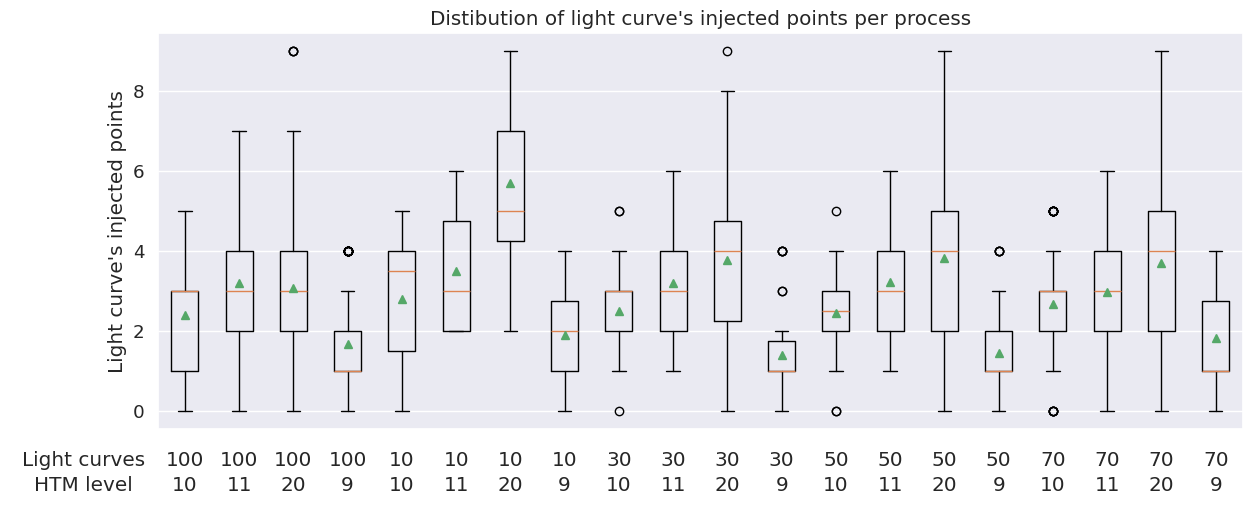

In [67]:
# Distribution of points extracted per light curve for each combination of HMTlevel and injected light curve
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

main_folder = "runs/test_10_calexps"
data_counts = []
pts_values = []
lvl_values = []

for subfolder in sorted([file for file in os.listdir(main_folder) if file.startswith("run")]):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):
        match = re.match(r'run_(\d+)pts_(\d+)lvl', subfolder)
        if match:
            pts, lvl = match.groups()
            pts_values.append(pts)
            lvl_values.append(lvl)

            mag_counts = []
            for file in os.listdir(subfolder_path):
                if file.endswith(".csv"):
                    file_path = os.path.join(subfolder_path, file)
                    df = pd.read_csv(file_path)
                    if "mag" in df.columns:
                        mag_count = df["mag"].count() 
                        mag_counts.append(mag_count)
            if mag_counts:
                data_counts.append(mag_counts)

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(14, 6))
gs = GridSpec(2, 1, height_ratios=[9, 1], hspace=0.1)  

ax_boxplot = fig.add_subplot(gs[0])
ax_boxplot.boxplot(data_counts, showmeans=True)
ax_boxplot.set_ylabel("Light curve's injected points")
ax_boxplot.set_title("Distibution of light curve's injected points per process")
ax_boxplot.set_xticks([])  

ax_table = fig.add_subplot(gs[1])
ax_table.axis("off")  

table_data = [pts_values, lvl_values]
row_labels = ["Light curves", "HTM level"]
table = ax_table.table(cellText=table_data, rowLabels=row_labels,loc="center", cellLoc='center', rowLoc='center')

for cell in table.properties()['celld'].values():
    cell.set_linewidth(0)  

table.scale(1, 1.5) 
plt.savefig(main_folder+"/injected_points_per_lc_analysis.png")
plt.show()

### Sources analysis

Text(0.5, 1.0, 'Number of sources per calexp (total = 36)')

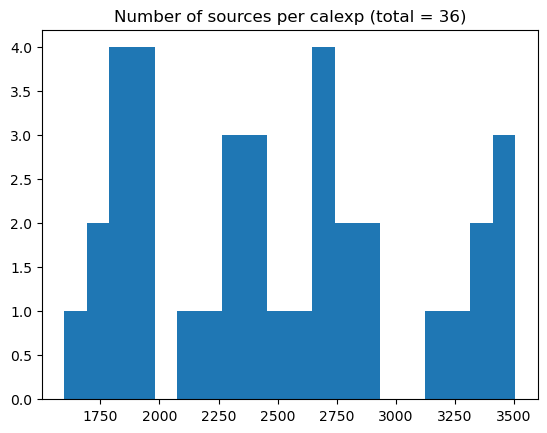

In [17]:
import matplotlib.pyplot as plt
plt.hist(n_sources, bins = 20)
plt.title(f"Number of sources per calexp (total = {len(n_sources)})")